In [22]:
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

In [23]:
# Add run name 
RUN_NAME = "run_256"

In [24]:
# Load the data
data = pd.read_csv("input/data/Tesla_Nasdaq_Prediction.csv")

In [44]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,4/8/2022,1025.49,18337900,1043.21,1048.44,1022.44
1,4/7/2022,1057.26,26482350,1052.39,1076.59,1021.54
2,4/6/2022,1045.76,29782850,1073.47,1079.00,1027.70
3,4/5/2022,1091.26,26691670,1136.30,1152.87,1087.30
4,4/4/2022,1145.45,27392570,1089.38,1149.91,1072.53


In [25]:
# Prepare the dataset
features = data.iloc[:, 2:].values
target = data['Close/Last'].values

In [26]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
type(X_train)

numpy.ndarray

In [28]:

# Scale the features and target
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [29]:

# Reshape input to be [samples, time steps, features] which is required for RNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [30]:
type(X_train_reshaped)

numpy.ndarray

In [31]:
# Build the RNN model
model = Sequential([
    SimpleRNN(256, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True, name='rnn_layer_1'),
    Dropout(0.25, name='dropout_layer_1'),
    SimpleRNN(128, return_sequences=True, name='rnn_layer_2'),
    Dropout(0.25, name='dropout_layer_2'),
    SimpleRNN(64, name='rnn_layer_3'),
    Dense(1, name='output_layer')
])

C:\Users\Muhammad_Haris\miniconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [33]:
# Create a TensorBoard logger

logger = TensorBoard(
    log_dir="output/log/{}".format(RUN_NAME),
    histogram_freq=5,
    write_graph=True,
    write_images=True
)

In [34]:
# Train the model
history = model.fit(
    X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, validation_split=0.1, verbose=1,callbacks=[logger]
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.0148 - val_loss: 1.2233e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 5.5803e-05
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1761e-04 - val_loss: 1.2380e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4414e-04 - val_loss: 4.0236e-05
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.1164e-04 - val_loss: 6.5161e-05
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.3543e-04 - val_loss: 2.0026e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.6519e-04 - val_loss: 2.5308e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.2985e-04 - val_loss: 9.1357e-05
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8428e-04 - val_loss: 3.6408e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.7016e-04 - val_loss: 2.7504e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.6275e-04 - val

In [35]:
# Predict and inverse transform the predictions
preds_scaled = model.predict(X_test_reshaped)
preds = scaler.inverse_transform(preds_scaled)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


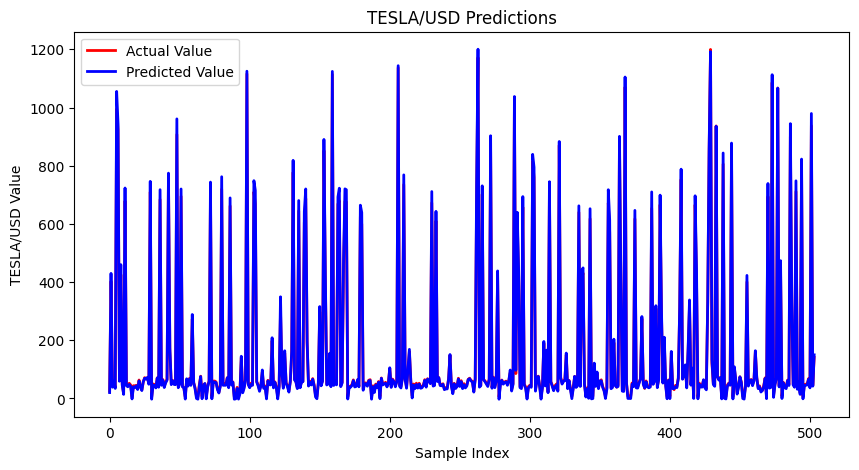

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Value', color='red', linewidth=2)
plt.plot(preds, label='Predicted Value', color='blue', linewidth=2)
plt.title('TESLA/USD Predictions')
plt.xlabel('Sample Index')
plt.ylabel('TESLA/USD Value')
plt.legend()
plt.show()
plt.savefig('output/fig/TESLA_USD_Predictions.png')
plt.clf()  # Clear the current figure

In [37]:
# Calculate metrics
mae_score = mean_absolute_error(y_test, preds)
mse_score = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

In [38]:
# Output the evaluation results
print(f"MAE Score: {mae_score}")
print(f"MSE Score: {mse_score}")
print(f"R2 Score: {r2 * 100}%")

MAE Score: 8.335304908528256
MSE Score: 199.65394890300365
R2 Score: 99.69457827743132%


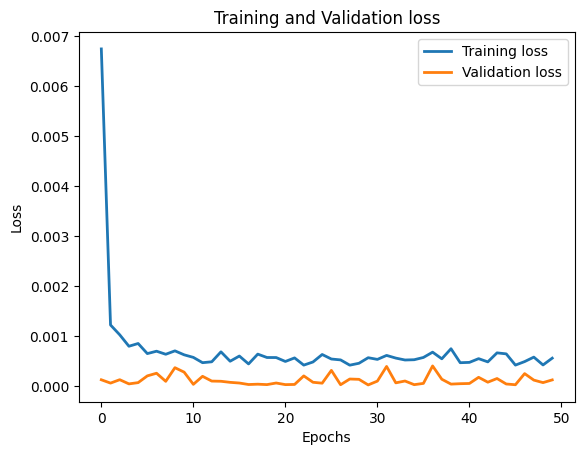

<Figure size 640x480 with 0 Axes>

In [39]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation loss', linewidth=2)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('output/fig/Training_validation_loss.png')
plt.clf()  # Clear the current figure

In [40]:
# Save the model for future use
model.save("output/model/trained_model.h5")
print("Model saved")

# To load the model:
# from keras.models import load_model
# model = load_model("output/model/trained_model.h5")

Model saved


In [41]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
%tensorboard --logdir=output/log
